In [9]:
!pip install pytrends

In [10]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pytrends.request import TrendReq
import time

In [11]:
pytrends = TrendReq(hl='en-US', tz=360)
kw_list = ["Jobs","Welfare","Unemployment","Food Stamps","EBT",]
pytrends.build_payload(kw_list, cat=0, timeframe='today 5-y', geo='US')
df=pytrends.interest_over_time()
df.head()

,Jobs,Welfare,Unemployment,Food Stamps,EBT,isPartial
date,,,,,,
2016-05-08,57,1,5,1,1,False
2016-05-15,58,1,5,1,1,False
2016-05-22,57,1,4,1,1,False
2016-05-29,54,1,4,1,1,False
2016-06-05,56,1,5,1,1,False


In [12]:
pytrends.build_payload(kw_list, cat=0, timeframe='2016-01-01 2017-01-01', geo='US')


In [60]:
kw_list =  ["Jobs","Welfare","Unemployment","Food Stamps","Food Bank","Work Near Me","Inflation","Economy","Recovery","Virus",""]
print(len(kw_list))


10


In [63]:
import time

dfs=[]
for k in range(0,len(kw_list),5):
    pytrends = TrendReq(hl='en-US', tz=360)
    tmpDF=None
    for i in range(4,21):
        if i<9:
            timeFrame="200"+str(i)+"-01-01 "+"200"+str(i+1)+"-01-01"
        elif i==9:
            timeFrame='2009-01-01 2010-01-01'
        elif i>-10:
            timeFrame="20"+str(i)+"-01-01 "+"20"+str(i+1)+"-01-01"
        pytrends.build_payload(kw_list[k:k+5], cat=0, timeframe=timeFrame, geo='US')
        df=pytrends.interest_over_time()
        try:
            df=df.drop(columns=["isPartial"])
        except KeyError:
            pass
        if not df.empty:
            tmpDF= df if i==4 else tmpDF.append(df)
    dfs.append(tmpDF)

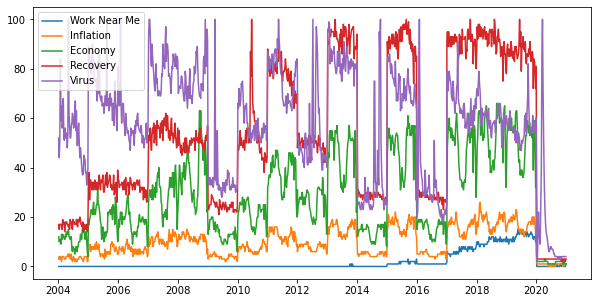

In [78]:
plt.figure(figsize=(10, 5))
plt.plot(tmpDF)
plt.legend(tmpDF.columns)

In [66]:
current.head()
tmpDF.head()
cur=dfs[0]
for i in dfs[1:len(dfs)]:
    cur = cur.merge(i, left_index=True, right_index=True)
cur.head()

,Jobs,Welfare,Unemployment,Food Stamps,Food Bank,Work Near Me,Inflation,Economy,Recovery,Virus
date,,,,,,,,,,
2004-01-04,99,4,9,0,0,0,3,12,17,52
2004-01-11,97,3,10,1,1,0,4,10,15,44
2004-01-18,98,2,11,1,1,0,3,11,17,52
2004-01-25,90,3,9,1,0,0,4,10,17,84
2004-02-01,85,3,10,0,1,0,3,9,17,59


In [68]:
cur.to_excel("trends.xlsx")  

In [43]:

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    index=dataset.index[interval:len(dataset)]
    columns=dataset.columns
    d={}
    for j in range(len(columns)):
        tmp=[]
        for i in range(interval, len(dataset)):
            value = dataset[columns[j]][i] - dataset[columns[j]][i - interval]
            tmp.append(value)
        d[columns[j]]=tmp
    diffs=pd.DataFrame(d)
    diffs=diffs.set_index(index)
    return (diffs)

In [44]:
df=pd.read_excel("trends.xlsx")
df=df.set_index("date")
new=difference(df)
new.to_excel("DifferencedTrends.xlsx")  

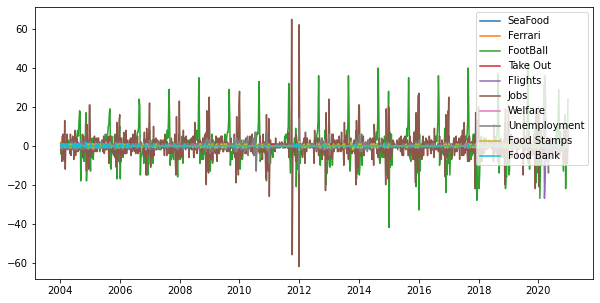

In [45]:
plt.figure(figsize=(10, 5))
plt.plot(new.index,new)
plt.legend(new.columns)

In [76]:
from statsmodels.tsa.stattools import adfuller

In [83]:
for i in tmpDF.columns:
    print("ADF Test for: ", i)
    result = adfuller(new[i])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

ADF Test for:  Jobs
ADF Statistic: -14.701359
p-value: 0.000000
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569
ADF Test for:  Welfare
ADF Statistic: -12.238815
p-value: 0.000000
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569
ADF Test for:  Unemployment
ADF Statistic: -11.853655
p-value: 0.000000
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569
ADF Test for:  indeed
ADF Statistic: -13.183691
p-value: 0.000000
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569
ADF Test for:  ZipRecruiter
ADF Statistic: -7.745314
p-value: 0.000000
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569


In [85]:

"""Citation: https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
I used the above source to perform granger causality tests on the data"""
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(new, variables = new.columns)    

,Jobs_x,Welfare_x,Unemployment_x,indeed_x,ZipRecruiter_x
Jobs_y,1.0000,0.0000,0.5582,0.2049,0.4038
Welfare_y,0.0005,1.0000,0.1378,0.0304,0.0186
Unemployment_y,0.0000,0.0003,1.0000,0.0000,0.7043
indeed_y,0.0359,0.0000,0.2325,1.0000,0.0472
ZipRecruiter_y,0.0627,0.1028,0.8684,0.0000,1.0000
